## Logistics

We are going to use parallel-tempering, implemented via the python emcee package, to explore our posterior, which consists of the set of distances to the twelve velocity slices. Since we need to explore a twelve dimensional parameter space, we are going to use 50 walkers, 500 steps each, at 5 different temperatures. If you would like to edit this parameters, simply edit "nwalkers", "ntemps", and "nsteps" in the cell below. However, we are only going to keep the lowest temperature chain ($\beta=1$) for analysis. Since the sampler.chain object from PTSampler returns an array of shape (Ntemps, Nwalkers, Nsteps, Ndim), returning the samples for all walkers, steps, and dimensions at $\beta=1$ would correspond to sampler.chain[0,:,:,:]. To decrease your value of $\beta$ simply increase the index for the first dimension. For more information on how PTSampler works, see http://dan.iel.fm/emcee/current/user/pt/. We will set off our walkers in a ball around the kinematic distance estimates for the Cepheus molecular cloud given by a flat rotation curve from Leroy & Rosolowsky 2006. You can edit the starting positions of the walkers by editing the "result" variable below.  

### Setting up the positional arguments for PTSampler

We need to feed PTSampler the required positional arguments for the log_likelihood and log_prior function. We do this using the fetch_args function from the io module, which creates an instance of the pixclass object that holds our data and metadata. Fetch_args accepts three arguments: 

- A string specifiying the h5 filename containing your data, in our case 89996.h5
- The prior bounds you want to impose on the distances (flat prior), in units of distance modulus. This is given as a list in the format [lowerbound, upperbound]. This must be between 4 and 19, because that's the distance modulus range of our stellar posterior array. 
- The gas-to-dust coefficient you'd like to use, given as a float; for this tutorial, we are pulling a value from the literature of 0.06 magnitudes/K. 

Fetch_args will then return the correct arguments for the log_likelihood and log_prior functions within the model module. 

Here we go!

In [1]:
import emcee
from dustcurve import model_speed
import seaborn as sns
import numpy as np
from dustcurve import pixclass
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io_speed
from dustcurve import hputils
from dustcurve import kdist
%matplotlib inline

#this code pulls snippets from the PHYS201 week 9 MCMC notebook written by Vinny Manohoran and the PHYS201 L9 solutions,
#written by Tom Dimiduk and Kevin Shain

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

#fetch the filenames corresponding to our region of interest:
#indices=hputils.list_indices(128,(109,110,13,14)).astype(str)
#fnames=[str(i)+'.h5' for i in indices]

fnames='89996.h5'

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io_speed.fetch_args(fnames,[4,19],0.06)

# the model has 12 parameters; we'll use 50 walkers, 500 steps each, at 5 different temps
ndim=12
nwalkers = 50
nsteps = 500
ntemps=5

#setting off the walkers at the kinematic distance given by the literature, assuming a flat rotation curve, theta=220 km/s, R=8.5 kpc
#Details on rotation curve given in Rosolowsky and Leroy 2006
vslices=np.linspace(-15.6,-1.3,12)
klong=np.ones(12)*109.5
klat=np.ones(12)*13.5
kdist=kdist.kdist(klong,klat,vslices)
kdistmod=5*np.log10(kdist)-5

#slightly perturb the starting positions for each walker, in a ball centered around result
starting_positions = [[kdistmod + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

print("Setup complete")

unique_co,indices,post_array,ratio=ldata



/n/home12/czucker/envs/PYTHON3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Total number of stars used in analysis: 3065
Setup complete


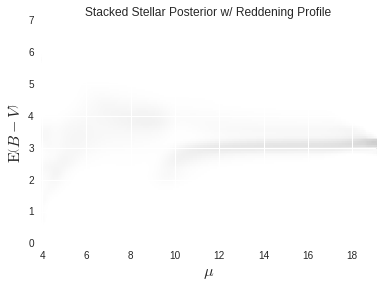

In [17]:
def plot_posterior(unique_co, post_array, xpts,ypts,normcol=False): 
    #normalize stellar posterior surfaces
    
    dispsurf = post_array.copy()
    dispsurf[~np.isfinite(dispsurf)] = 0
    norm = np.sum(np.sum(dispsurf, axis=1), axis=1)+1.e-40
    totsurf = np.sum(dispsurf/norm.reshape(-1,1,1), axis=0)
    
    if normcol==True:
        colmin = np.min(totsurf, axis=1)
        dispsurf = totsurf-colmin.reshape(-1,1)
        dispsurf = dispsurf/np.sum(dispsurf, axis=1).reshape(-1,1)

    #setup and plot normalized stacked stellar posterior
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Stacked Stellar Posterior w/ Reddening Profile")
    ax.set_xlabel(r'$\mu$', fontsize=16)
    ax.set_ylabel(r'$\mathrm{E} \left( B - V \right)$', fontsize=16)
    if xpts is not None and ypts is not None:
        dx = np.median(xpts[1:]-xpts[:-1])
        dy = np.median(ypts[1:]-ypts[:-1])
        extent = [xpts[0]-dx/2., xpts[-1]+dx/2.,
                            ypts[0]-dy/2., ypts[-1]+dy/2.]

    ax.imshow(dispsurf.T,origin='lower',aspect='auto', cmap='binary', interpolation='nearest', vmin=0,vmax=1, extent=extent)

    
plot_posterior(unique_co,post_array,np.linspace(4,19,120),np.linspace(0,7,700), normcol=True)



In [5]:
#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model_speed.log_likelihood, model_speed.log_prior, loglargs=(ldata), logpargs=[pdata])

# run the sampler and time how long it takes
%time sampler.run_mcmc(starting_positions, nsteps)
print('Sampler Done')

CPU times: user 4h 41min 2s, sys: 17h 4min 7s, total: 21h 45min 9s
Wall time: 21h 45min 46s
Sampler Done


The sampler is done running, so now let's check out the results. We are going to print out our mean acceptance fraction across all walkers for the coldest temperature chain. 

We are going to discard the first 300 steps of each chain as burn-off; to change the number of steps to burn off, simply edit the 3rd dimension of sampler.chain[0,:,n:,:] and input your desired value of n. Next we are going to plot what the chains look like, for each distance parameter and for the first ten walkers. The chains should all be reasonably well-mixed. Finally, we are going to compute and print out the 50th, 16th, and 84th percentile of chain for each distance parameter, using the "quantile" attribute of a pandas dataframe object (in our case "parameter_samples"). The 50th percentile measurement represents are best guess for the each distance parameter, while the 16th and 84th percentile parameter give us a sense of the uncertainty. 

Our mean acceptance fraction for the coldest chain is 0.00
d1= 10.36 + 0.09 - 0.08
d2= 10.09 + 0.09 - 0.10
d3= 9.81 + 0.13 - 0.08
d4= 9.48 + 0.10 - 0.13
d5= 9.10 + 0.09 - 0.11
d6= 8.55 + 0.07 - 0.10
d7= 7.90 + 0.11 - 0.11
d8= 6.84 + 0.07 - 0.08
d9= 4.73 + 0.11 - 0.10
d10= 4.13 + 0.07 - 0.09
d11= 6.78 + 0.08 - 0.11
d12= 7.96 + 0.09 - 0.10


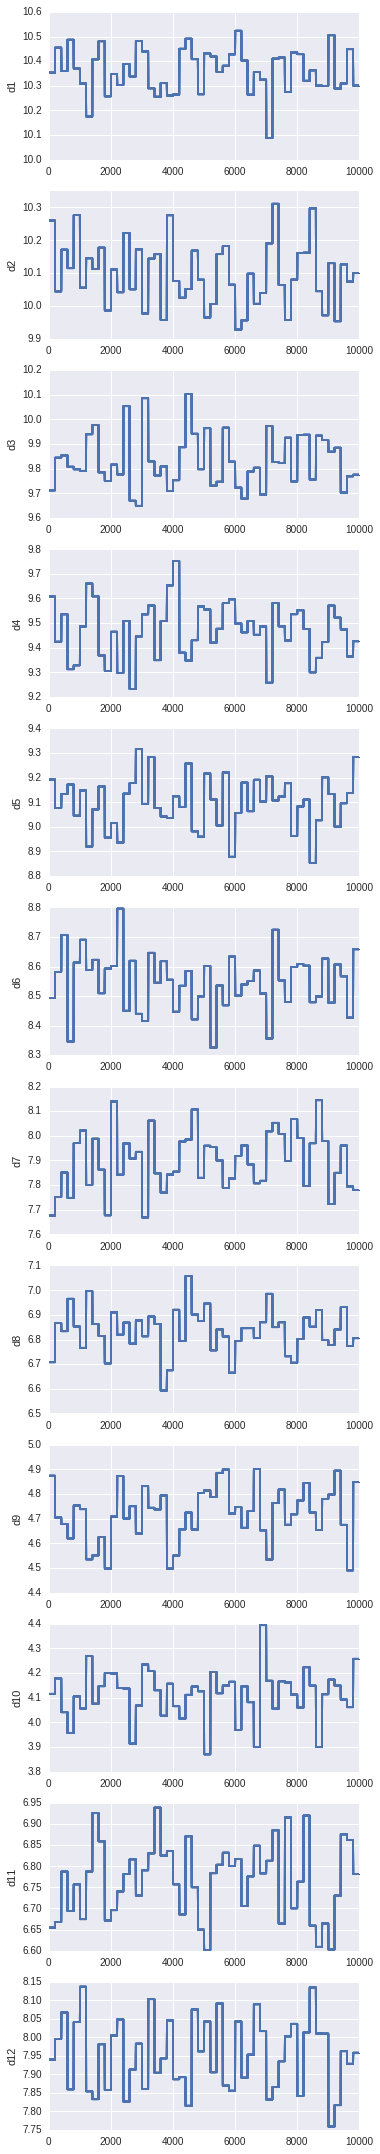

In [7]:
#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#discard the first 300 steps as burn-off and resshape the array
samples_cold = sampler.chain[0,:,300:,:]
traces_cold = samples_cold.reshape(-1, ndim).T
    
#set up subplots for chain plotting
fig, (ax_d1, ax_d2, ax_d3, ax_d4, ax_d5, ax_d6, ax_d7, ax_d8, ax_d9, ax_d10, ax_d11, ax_d12) = plt.subplots(12, figsize=(5,30))

plt.tight_layout()

#label axes
ax_d1.set(ylabel='d1')
ax_d2.set(ylabel='d2')
ax_d3.set(ylabel='d3')
ax_d4.set(ylabel='d4')
ax_d5.set(ylabel='d5')
ax_d6.set(ylabel='d6')
ax_d7.set(ylabel='d7')
ax_d8.set(ylabel='d8')
ax_d9.set(ylabel='d9')
ax_d10.set(ylabel='d10')
ax_d11.set(ylabel='d11')
ax_d12.set(ylabel='d12')

#plot chains for each parameter, for first 10 walkers
for i in range(10):
    sns.tsplot(traces_cold[0], ax=ax_d1)
    sns.tsplot(traces_cold[1], ax=ax_d2)
    sns.tsplot(traces_cold[2], ax=ax_d3)
    sns.tsplot(traces_cold[3], ax=ax_d4)
    sns.tsplot(traces_cold[4], ax=ax_d5)
    sns.tsplot(traces_cold[5], ax=ax_d6)
    sns.tsplot(traces_cold[6], ax=ax_d7)
    sns.tsplot(traces_cold[7], ax=ax_d8)
    sns.tsplot(traces_cold[8], ax=ax_d9)
    sns.tsplot(traces_cold[9], ax=ax_d10)
    sns.tsplot(traces_cold[10], ax=ax_d11)
    sns.tsplot(traces_cold[11], ax=ax_d12)

    
#store the chain information
parameter_samples = pd.DataFrame({'d1': traces_cold[0], 'd2': traces_cold[1], 'd3': traces_cold[2], 
                                  'd4': traces_cold[3], 'd5': traces_cold[4], 'd6': traces_cold[5],
                                  'd7': traces_cold[6], 'd8': traces_cold[7], 'd9': traces_cold[8],
                                  'd10': traces_cold[9], 'd11': traces_cold[10], 'd12': traces_cold[11]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

#what values do we get?
for i in range(1,13):
    print("d"+str(i)+"= {:.2f} + {:.2f} - {:.2f}".format(q["d"+str(i)][0.50], 
                                                q["d"+str(i)][0.84]-q["d"+str(i)][0.50],
                                                q["d"+str(i)][0.50]-q["d"+str(i)][0.16]))

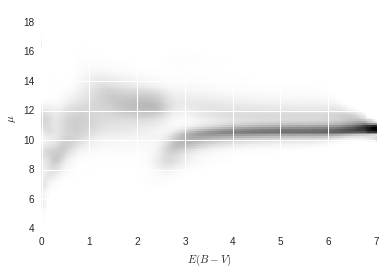

In [3]:
%matplotlib inline
unique_co,indices,post_array,ratio=ldata

from dustcurve import plot_posterior
plot_posterior.plot_fit(post_array, np.linspace(0,7,700), np.linspace(4,19,120), normcol=True)


In [19]:
import h5py
#Save the results of the sampler:
output=fnames

fwrite = h5py.File("/n/fink1/czucker/Output/"+str(output), "w")
chaindata = fwrite.create_dataset("/chains", sampler.chain.shape, dtype='f')
chaindata[:,:,:,:]=sampler.chain
    
probdata = fwrite.create_dataset("/probs", sampler.lnprobability.shape, dtype='f')
probdata[:,:,:]=sampler.lnprobability


fwrite.close()